In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

In [2]:
N = 200
a = 0.5
b = 1
l = 2
s2 = 0.5 # actually is s

In [3]:
def generate_x(N):
    return np.random.exponential(scale=l, size=(N, 1))

In [4]:
def explonential_pdf():
    x = np.linspace(0, 5*l, 400)
    return x, 1/l * np.exp(-x / l)

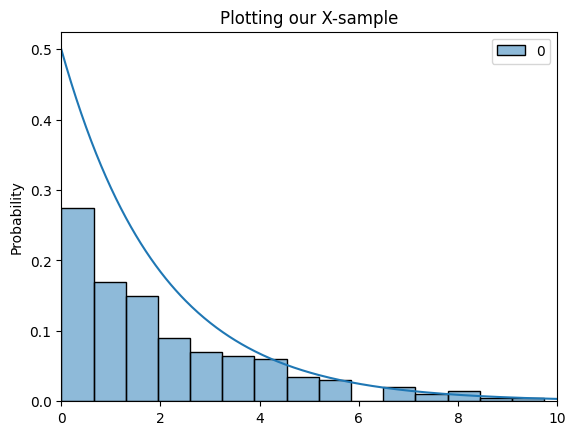

In [5]:
x = generate_x(N)
sns.histplot(x, stat="probability", bins=15)
plot_dom, pdf = explonential_pdf()
plt.plot(plot_dom, pdf)
plt.title("Plotting our X-sample")
plt.xlim(0, 5*l)
plt.show()

In [6]:
def generate_y(x, N):
    y = a + b * x
    noise = np.random.normal(0, np.sqrt(s2), (N, 1))
    y = y + noise
    y = np.resize(y, (N))
    x = np.resize(x, (N))
    return x, y

def generate_data(N):
    x = generate_x(N)
    x, y = generate_y(x, N)
    return x, y

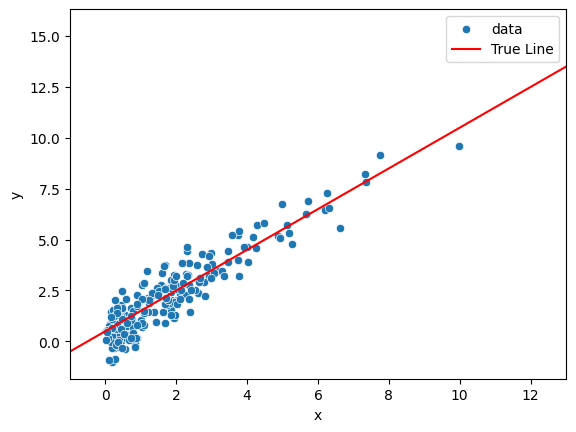

In [7]:
x, y = generate_data(N)
sns.scatterplot(data = {'x': x, 'y': y}, x = 'x', y = 'y', label = 'data')
plt_dom = np.linspace(-1, 15)
line_y = a + plt_dom * b
plt.plot(plt_dom, line_y, color = 'red', label = 'True Line')
plt.xlim(-1, 13)
plt.legend()
plt.show()

Let us first try to estimate parameters using ALL the data

In [8]:
def linear_reg(x, y):
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    b1 = np.sum((y - mean_y) * (x - mean_x)) / np.sum((x - mean_x)**2)
    a1 = mean_y - b1 * mean_x
    s1 = np.sum((y - (a1 + b1 * x))**2) / N
    return a1, b1, s1

def estimate_lambda(x):
    return np.mean(x)

In [9]:
ae, be, se = linear_reg(x, y)
le = estimate_lambda(x)

print(f"""
Estimating Parameters:
      True a = {a},  estimated a = {ae}
      True b = {b},  estimated b = {be}
      True l = {l},  estimated l1 = {le}
      True s2 = {s2}, estimated s2 = {se}
""")


Estimating Parameters:
      True a = 0.5,  estimated a = 0.4109210862819015
      True b = 1,  estimated b = 1.032004895773576
      True l = 2,  estimated l1 = 1.8054574152151108
      True s2 = 0.5, estimated s2 = 0.5518362468515577



In [10]:
def delete_random_x(x, delete_n):
    indices = list(np.random.choice(range(N), delete_n))
    print("Deleting: ", indices)
    x_copy = np.copy(x)
    for i in indices:
        print("Deleting value,", x[i])
        x_copy[i] = np.nan
    return x_copy, indices

In [11]:
x_del, indices = delete_random_x(x, 1)

Deleting:  [np.int64(15)]
Deleting value, 0.12482999604194754


In [12]:
def em_step(x, y, indices, a1, b1, l1, s21):
    k = len(indices)
    non_missing_x = np.array([x[i] for i in range(N) if i not in indices])
    non_missing_y = np.array([y[i] for i in range(N) if i not in indices])
    missing_y = np.array([y[i] for i in indices])
    y_mean = np.mean(y)
    x0 = 1/N * (k * l1 + np.sum(non_missing_x))
    
    b2 = np.sum((non_missing_x - x0) * (non_missing_y - y_mean)) + np.sum((l1 - x0) * (missing_y - y_mean))
    b2 = b2 / (k * l1**2 + k * (l1 - x0)**2 + np.sum((non_missing_x - x0)**2))

    a2 = y_mean - b2 * x0

    l2 = (np.sum(non_missing_x) + k*l1)/N

    s22 = 1/N * (np.sum((non_missing_y - (a2 + b2 * non_missing_x))**2) 
                 + np.sum((missing_y - (a2 + b2 * l1))**2 + (l1 * b2)**2))

    return a2, b2, l2, s22

In [13]:
def em(x, y, indices, iterations=100):
    a1, b1, l1, s21 = np.random.uniform(0, 2, 4)
    a_list = []
    b_list = []
    l_list = []
    s_list = []
    a_list.append(a1)
    b_list.append(b1)
    l_list.append(l1)
    s_list.append(s21)
    print(a1, b1, l1, s21)
    for i in range(iterations):
        a1, b1, l1, s21 = em_step(x, y, indices, a1, b1, l1, s21)
        a_list.append(a1)
        b_list.append(b1)
        l_list.append(l1)
        s_list.append(s21)
        if i % 10 == 0:
            print(i, a1, b1, l1, s21)
    return a1, b1, l1, s21, a_list, b_list, l_list, s_list

In [14]:
a1, b1, l1, s1, a_list, b_list, l_list, s_list = em(x_del, y, indices, iterations=30)

1.3609170343802293 0.9832578775573189 1.0529857630512545 0.7929667282731883
0 0.4081294454109097 1.0309012729902678 1.8100981940501573 0.5647986291172769
10 0.41379116599903343 1.0256177085672076 1.8139027791305538 0.5888955747963303
20 0.41379116599903343 1.0256177085672076 1.8139027791305538 0.5888955747963303


In [15]:
print(f"""
Estimating Parameters:
      True          Estimated               EM
a   {a:.4f}             {ae:.4f}           {a1:.4f}
b   {b:.4f}             {be:.4f}           {b1:.4f}
l   {l:.4f}             {le:.4f}           {l1:.4f}
s2  {s2:.4f}             {se:.4f}           {s1:.4f}
""")


Estimating Parameters:
      True          Estimated               EM
a   0.5000             0.4109           0.4138
b   1.0000             1.0320           1.0256
l   2.0000             1.8055           1.8139
s2  0.5000             0.5518           0.5889



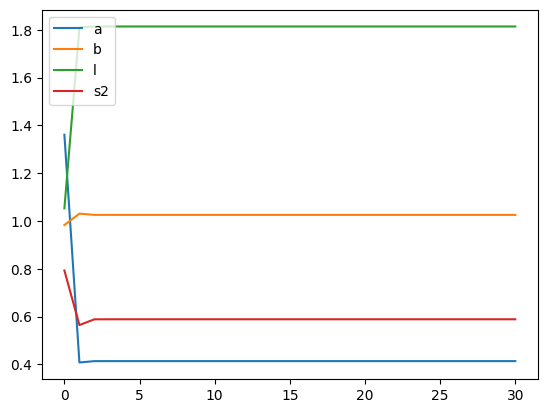

In [16]:
plt.plot(a_list, label='a')
plt.plot(b_list, label='b')
plt.plot(l_list, label='l')
plt.plot(s_list, label='s2')
plt.legend()

In [17]:
a1, b1, l1, s1, a_list, b_list, l_list, s_list = em(x, y, indices, iterations=30)

1.1762281775573988 1.924524401348621 0.028371434601266232 1.1369186509980236
0 0.4118773584687332 1.0317508514696359 1.8049751224079071 0.5516301338648526
10 0.41379116599903343 1.0256177085672076 1.8139027791305538 0.5888955747963303
20 0.41379116599903343 1.0256177085672076 1.8139027791305538 0.5888955747963303


Deleting a LOT!

In [18]:
x_del, indices = delete_random_x(x, 20)

Deleting:  [np.int64(151), np.int64(150), np.int64(140), np.int64(27), np.int64(197), np.int64(193), np.int64(195), np.int64(191), np.int64(117), np.int64(108), np.int64(156), np.int64(187), np.int64(32), np.int64(199), np.int64(76), np.int64(5), np.int64(106), np.int64(77), np.int64(129), np.int64(124)]
Deleting value, 2.427279334231217
Deleting value, 2.2923528445470764
Deleting value, 1.2219191807152274
Deleting value, 0.4310202020389525
Deleting value, 2.8152787937120536
Deleting value, 1.658994971608156
Deleting value, 0.15745707474023038
Deleting value, 2.3094260838585257
Deleting value, 1.5047565076779672
Deleting value, 5.174500033552884
Deleting value, 3.5815854584505864
Deleting value, 0.0868265300197683
Deleting value, 0.7512979936256787
Deleting value, 0.8883609022267581
Deleting value, 0.8988891438359291
Deleting value, 0.22898166945970347
Deleting value, 3.0752408071632455
Deleting value, 4.161102216172917
Deleting value, 0.47998846350095903
Deleting value, 4.937639976838

In [19]:
a1, b1, l1, s1, a_list, b_list, l_list, s_list = em(x_del, y, indices, iterations=30)

0.25219489525680006 1.031153111794166 0.989068881143434 0.4649212224033985
0 0.6198100145778673 0.968051812477455 1.7089498123895746 1.017020885263661
10 0.6112806016043344 0.9295362354029355 1.788936582520036 1.0877318061575898
20 0.6112806016099877 0.9295362353956192 1.7889365825280348 1.0877318061747319


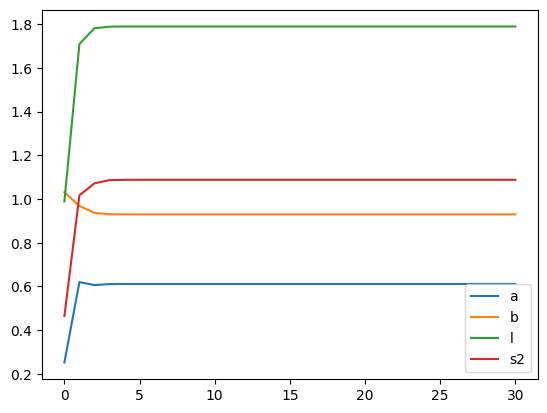

In [20]:
plt.plot(a_list, label='a')
plt.plot(b_list, label='b')
plt.plot(l_list, label='l')
plt.plot(s_list, label='s2')
plt.legend()

In [21]:
print(f"""
Estimating Parameters:
      True          Estimated               EM
a   {a:.4f}             {ae:.4f}           {a1:.4f}
b   {b:.4f}             {be:.4f}           {b1:.4f}
l   {l:.4f}             {le:.4f}           {l1:.4f}
s2  {s2:.4f}             {se:.4f}           {s1:.4f}
""")


Estimating Parameters:
      True          Estimated               EM
a   0.5000             0.4109           0.6113
b   1.0000             1.0320           0.9295
l   2.0000             1.8055           1.7889
s2  0.5000             0.5518           1.0877

